## **Lecture: Support Vector Machines** (Stroke Data Set)
Support-vector machines (SVMs) are supervised learning models used for classification and regression analysis.  
 <p style="text-align: center;"> <img src= SVM.jpg width=900 alt='[img: SVM]'/>  </p>

---
### **The Question: Is the flower that we have measured a Iris Setosa?**  
For this we will use SVM to make a classifer that will train on a 100 datum training set and test on the remaining flowers.  

---

In [1]:
import numpy as np # Numpy
import pandas as pd # Pandas is a great tool for working with and displaying data.
import matplotlib.pyplot as plt # For plotting.
from tqdm import tqdm

### **Reading in the Data** 

In [3]:
RAW_DATA_FRAME = pd.read_csv('..//Data/healthcare/stroke/healthcare-dataset-stroke-data.csv') ## Load data
print(RAW_DATA_FRAME.keys())

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


In [4]:
RAW_DATA_FRAME = RAW_DATA_FRAME[["avg_glucose_level", "bmi", "stroke"]].dropna(axis=0)

In [5]:
#Colnames = ['SL', 'SW', 'PL', 'PW', 'Flower']
#RAW_DATA_FRAME.columns = Colnames 

# Make an index for different binary categories .
mapping = {1: -1, 0: 1}

# Map Setosa to -1 and the two other flowers to 1.
RAW_DATA_FRAME["stroke"] = [mapping[item] for item in RAW_DATA_FRAME["stroke"]]

RAW_DATA_FRAME.head()

,avg_glucose_level,bmi,stroke
0,228.69,36.6,-1
2,105.92,32.5,-1
3,171.23,34.4,-1
4,174.12,24.0,-1
5,186.21,29.0,-1


### **Working to make training and testing data** 

---

This next section of code allows us to plot different features with respect to each other. For this method of machine learning we are looking for a linear correlation.

In [6]:
##########################################################
# This is the set that controls what features we are using. (As well as the target)
ALL_DATA_LABELS = ["avg_glucose_level", "bmi", "stroke"]

In [7]:
ALL_DATA_SHUFFLED = RAW_DATA_FRAME[ALL_DATA_LABELS].sample(frac=1) # Shuffle the data frame
TRAINING = ALL_DATA_SHUFFLED[:4000] # Build the training.
TESTING = ALL_DATA_SHUFFLED[4000:] # Build the testing set.

In [8]:
TESTING.head() # Print a part of the testing set to see that it is working.
np.unique(ALL_DATA_SHUFFLED["stroke"], return_counts=True)

(array([-1,  1]), array([ 209, 4700]))

In [9]:
# Make the training sets. One for the features and one for the targets.
X_TRAIN = np.array(TRAINING.drop("stroke",  axis=1))
Y_TRAIN = np.array(TRAINING["stroke"])

In [10]:
# Make the testing sets. One for the features and one for the targets.
X_TEST = np.array(TESTING.drop("stroke",  axis=1))
Y_TEST = np.array(TESTING["stroke"])

### **Statistical Analysis**

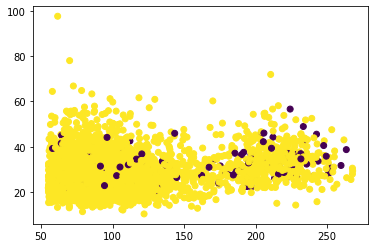

In [11]:
# Plot the data. 
plt.scatter(TRAINING[ALL_DATA_LABELS[0]], TRAINING[ALL_DATA_LABELS[1]],c = TRAINING["stroke"])
plt.show()

### **Support Vector Machines**  
**The Math**  

In [12]:
TESTING.head() # Look at a piece of the training data.

,avg_glucose_level,bmi,stroke
853,74.51,36.6,1
4297,76.64,34.6,1
2151,93.88,24.3,1
3730,76.10,32.1,1
660,69.37,36.2,1


Source: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

We need a Cost function and its gradients. The cost function that we will use for SVM is the hinge loss:

$$HL(w_1,w_2,w_3, ... ,w_m) = min_w \lambda |\mathbf{w}|^2 + \sum_{i = 1}^{N} \textrm{max}(0,1-  y_i \langle \mathbf{x}_i, \mathbf{w} \rangle) $$  
where $$ y_i = \begin{cases} 
      -1 & y_i \ \ \textbf{Iris Setosa} \\
      1 & y_i \ \ \textbf{Not Iris Setosa }
   \end{cases} $$
and the "gradients" will be,  
$$ \frac{\partial}{\partial w_k} \textrm{max}(0, y_k \langle \mathbf{x}_k, \mathbf{w} \rangle) = \begin{cases} 
      0 & \ \ \textrm{if}, \ y_k \langle \mathbf{x}_k, \mathbf{w} \rangle < 0 \\
      -y_kx_k & \ \ \textrm{else}
   \end{cases} $$

and,

$$ \frac{\partial}{\partial w_k} min_w \lambda |\mathbf{w}|^2 = 2 \lambda w_k $$  

So, the gradients will be different depending on the sign of $\displaystyle  y_k \langle \mathbf{x}_k, \mathbf{w} \rangle$.

If $\displaystyle  y_k \langle \mathbf{x}_k, \mathbf{w} \rangle > 0$ the predicted value was the same sign as the target, and we will update the weights with,
$$w_k = w_k - \alpha(2 \lambda w_k) $$  
If  $\displaystyle  y_k \langle \mathbf{x}_k, \mathbf{w} \rangle < 0$ the predicted value was a different sign than the target, and we will update the weights with,  
$$w_k = w_k - \alpha(2 \lambda w_k - y_kx_k),$$
with $\alpha$ in each case to set our step size (learning rate).

### **Bit of a change in structure**

The above is a deeper story of Hinge Loss and the error surface. I am going to modify it a bit to better showcase what is happening. 

For the code below, I am going to update the weights as follows,

If $\displaystyle  y_k \langle \mathbf{x}_k, \mathbf{w} \rangle > 0$ the predicted value was the same sign as the target, and we will update the weights with,
$$w_k = w_k  $$  
If  $\displaystyle  y_k \langle \mathbf{x}_k, \mathbf{w} \rangle < 0$ the predicted value was a different sign than the target, and we will update the weights with,  
$$w_k = w_k + \alpha y_kx_k,$$
with $\alpha$ in each case to set our step size (learning rate).

In [ ]:

def supportvectormachine(x, Y, learning_Rate, epochs):
    archive = []
    x =  np.append(x, np.array([np.ones(len(x))]).T, axis=1)
    weights = np.random.rand(len(x.T)) # One weight for each column of the feature set. (Another way to say it is a weight for each feature.)
    
    # Loop over all the data
    for i in tqdm(range(epochs)):
        
        # Create an arcive so that we can plot many different SVM lines.
        archive.append([i,weights[0], weights[1]])
         
        # Predict over all the x feature training data.
        y_pred = np.dot(x, weights)
        
        # Get the value of the true answer times the predicted value. (This is y * <x,w> above)
        value = Y * y_pred
        
        # Set a location. Since we will be working through all the data one at a time, this will keep our position.
        location = 0
        
        # Loop over all the data in the training set. Note in this loop t is set to an element of the array, value.
        for t in value:
            
            # The above sudogradient requires us to check the sign of one part of the gradient. So this gate will do that for us. 
            
            # Correct guess weight update.
            if t > 0:
                weights = weights  # - learning_Rate * (2 * 1 / epochs * weights )
            
            # Incorrect guess weight update.
            else:
                weights  = weights + learning_Rate * ( Y[location] * x[location] ) # - 2 * 1 / epochs * weights)
            
            # Move one location in the data set (we will need to do this for each epoch)
            location += 1
    
    # Return the weights, the list of intercepts and the list of slopes.
    return [weights, archive]

### **Training the Network** 

In [ ]:
EPOCHS = 1400 # Number of epochs.
LEARNING_RATE = .001# Learning rate.

w, A = supportvectormachine(X_TRAIN, Y_TRAIN, LEARNING_RATE, EPOCHS) # Run the SVM definition. (Train the model)
print(w) # Print our trained weights.


In [ ]:
# Development check that the numbers were in the correct range.
for i in range(5):
    check = np.dot(X_TEST[i].T,  w[:-1]) + w[-1]  # This is how we apply the trained model weights.
    print(check)

### **Assessment of the Network**

In [ ]:
from sklearn.metrics import accuracy_score
V = [] # Empty list to collect the predictions.

x = np.array(X_TRAIN) # Assign the testing data.
y = np.array(Y_TRAIN) # Assign the testing targets.

# Loop over all the testing features to get the classification probabilities.
for i in range(len(x)):
    V.append(np.dot(w[:-1], x[i]) + w[-1])

new_y_pred = [] # Empty list for the predictions.

# If the predicetion value is greater then 1, give it a value of 1 and if it is less than on give it a value of -1.
for val in V:
    if(val > 0):
        new_y_pred.append(1)
    else:
        new_y_pred.append(-1)    

# Print the findings. (I use sklearn to help with counting here.)
print("Total number correct: ", accuracy_score(y,new_y_pred, normalize = False))
print("Total number in the testing data: ", len(Y_TRAIN))
print("Accuracy Score", accuracy_score(y,new_y_pred, normalize = False) / len(Y_TRAIN) )

In [ ]:
# This min/max stuff is here to set the window size dynamically for different data sets. 
min0 = RAW_DATA_FRAME[[ALL_DATA_LABELS[0]]].min()
min1 = RAW_DATA_FRAME[[ALL_DATA_LABELS[1]]].min()
m = min(min0[0], min1[0])

max0 = RAW_DATA_FRAME[[ALL_DATA_LABELS[0]]].max()
max1 = RAW_DATA_FRAME[[ALL_DATA_LABELS[1]]].max()
n = min(max0[0], max1[0])

# Set the "continuous" domain of values for graphing the line.
t1 = np.arange(m, n,.01)

# Set the size of the figure.
fig = plt.subplots(figsize = (13,13))

#Plot many different lines from the archive. 
#for k in range(EPOCHS):
#    if k % 1000 == 0 and k != 0:
#        plt.plot(t1, t1 * - A[k][1] / A[k][0], alpha=0.5)
        
# Plot the data.
plt.scatter(RAW_DATA_FRAME[ALL_DATA_LABELS[0]], RAW_DATA_FRAME[ALL_DATA_LABELS[1]], c = RAW_DATA_FRAME["stroke"] , s = 10)
plt.plot(t1, t1 *  (- w[0] / w[1]) + (-w[-1]) / w[1], c = 'r' ) # Plot the final line.
plt.xlim(m, n)
plt.ylim(m, n)
plt.gca().set_aspect('equal', adjustable='box')
plt.show() # Show the entire plot.

---

### **Sklearn implementation**

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma='scale')
clf.fit(X_TRAIN, Y_TRAIN)

In [ ]:
W = []

for i in range(len(x)):
    W.append(clf.predict([X_TEST[i]]))

# Print the findings. (I use sklearn to help with counting here.)
print("Total number correct: ", accuracy_score(y,W, normalize = False))
print("Total number in the testing data: ", len(Y_TEST))

print("Accuracy Score", accuracy_score(y, W, normalize = False) / len(Y_TEST) )